In [1]:
import skrf as rf
from skrf.constants import K_BOLTZMANN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from devices.devices_lib import make_cavity__with_antennas_network # From Chirstan Boutan's PNNL team
import components as cmp # From Jihee

%matplotlib inline

No display found. Using non-interactive Agg backend.


In [2]:
freq = rf.frequency.Frequency(start=0.5, stop=1.5, npoints=1001, unit='ghz', sweep_type='lin')
Troom = 300 #K

In [3]:
###############################
##### Component Functions   ###
###############################
#(From Jihee's components.py and analyis_run1C_tsys.py)


### Function to read network in noisy environment ###
def read_in_noisy_network(ntw,freq_interp,Tphys):
    ntw_interp = ntw.interpolate(freq_interp, kind='cubic')
    ntw_interp_noisy = rf.NoisyNetwork(ntw_interp)
    ntw_interp_noisy.noise_source(source='passive',T0 = Tphys)

    return ntw_interp_noisy

### Function to make coaxial cable with coaxial line and SMA connector sample ###
def make_coax_cable(c_type,freq,len_m,Tphys):
        
    if c_type=='RG405U':
        ntw_coax_RT = cmp.cable_RG405U(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_RG405U(freq,0.04)
        ntw_SMA_RT = cmp.SMA_RG405U(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='PESR405FL':    
        ntw_coax_RT = cmp.cable_PESR405FL(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_PESR405FL(freq,0.04)
        ntw_SMA_RT = cmp.SMA_PESR405FL(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='NbTi085':
        ntw_coax_cryo = cmp.cable_NbTi085(freq,len_m)
        ntw_SMA_cryo = cmp.cable_NbTi085(freq,0.015)
    else:
        print('Error: Proper cable type is missing')

    noisy_ntw_coax = read_in_noisy_network(ntw_coax_cryo,freq,Tphys)
    noisy_ntw_SMA = read_in_noisy_network(ntw_SMA_cryo, freq, Tphys)
    
    assmb_cable = rf.MultiNoisyNetworkSystem()

    noisy_ntw_SMA.add_noise_polar(1e-6, 0.5)
    assmb_cable.add(noisy_ntw_SMA,'SMA1')
    assmb_cable.add(noisy_ntw_coax,'coax')
    noisy_ntw_SMA.add_noise_polar(1e-6, 0.55)
    assmb_cable.add(noisy_ntw_SMA,'SMA2')

    assmb_cable.connect('SMA1',2, 'coax',1)
    assmb_cable.connect('coax',2, 'SMA2',1)

    assmb_cable.external_port('SMA1',1,1)
    assmb_cable.external_port('SMA2',2,2)

    noisy_ntw_cable = assmb_cable.reduce()
    noisy_ntw_cable = read_in_noisy_network(noisy_ntw_cable,freq,Tphys)
        
    return noisy_ntw_cable  

## - how do I add an amplifier?
## - add in parts with specified values
## - calculation using friis formula on paper -- noise temperatures?

## - use S11 for one-port network noise power?

In [4]:
db_to_pow = lambda x: 10**(x/10)

def make_amplifier(freq,G):
    
    #G = 21.3 #db, Vdd = 5.0 V, typ at 2Ghz.
    
    RL_1 = 15.0 
    RL_2 = 11.0
    reverse_isolation_db = -21 #mouser.com, ZX60-83LN-S+

    A = np.sqrt( db_to_pow(G) )
    reflection_1 = np.sqrt( db_to_pow(RL_1) ) #Formula ???
    reflection_2 = np.sqrt( db_to_pow(RL_2) )
    
    isolation = np.sqrt( db_to_pow(reverse_isolation_db) ) 

    s = np.zeros((len(freq), 2, 2))

    s[:,0,0] = reflection_1
    s[:,0,1] = isolation
    s[:,1,0] = A
    s[:,1,1] = reflection_2
    
    return rf.Network(frequency=freq,s=s)
    
def make_ideal_amplifier(freq,G):
    
    #G = 21.3 #db, Vdd = 5.0 V, typ at 2Ghz.
    
    A = np.sqrt( 10**(G/10) )

    s = np.zeros((len(freq), 2, 2))
    
    eps=1e-12

    s[:,0,0] = eps
    s[:,0,1] = eps
    s[:,1,0] = A
    s[:,1,1] = eps
    
    return rf.Network(frequency=freq,s=s)

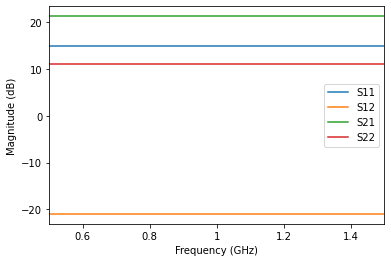

In [5]:
amp = make_amplifier(freq,21.3)
amp.plot_s_db()

In [6]:

### Plotting Cs matrix for cavity to second circulator

def plot_cs_simple_circuit():
    
    
        # Plot the power spectrum for the simple circuit setup in the lab. 
        # terminator -> cable -> amplifier -> spectrum analyzer
    
        #Terminator
        termi_temp = Troom
        ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # [[What determines gamma_0 here?]]
        noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, termi_temp) ## <------ function parameter

        #Cables
        LEN_CABLE1 = 0.01 #m
        LEN_CABLE2 = 0.01 #m

        noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom)
        noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)
        
        #Amplifier
        amplifier = make_amplifier(freq, 21.3)
        noisy_amp = read_in_noisy_network(amplifier,freq,Troom)

        # Assemble circuit
        mnns_simple_circ = rf.MultiNoisyNetworkSystem()


        mnns_simple_circ.add(noisy_ntw_cable_1,'cable1')
        mnns_simple_circ.add(noisy_ntw_cable_2,'cable2')
        mnns_simple_circ.add(noisy_ntw_termi,'termi')
        mnns_simple_circ.add(noisy_amp,'amp')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns_simple_circ.connect('termi',1,'cable1',2)
        mnns_simple_circ.connect('cable1',1,'amp',2)
        mnns_simple_circ.connect('amp',1,'cable2',2)

        mnns_simple_circ.external_port('cable2',1,1)

        assem_simple_circ = mnns_simple_circ.reduce()
        
        #print(assem_simple_circ.cs)

        plt.plot(freq.f/1e9,assem_simple_circ.cs[:,0])
        plt.xlim(0.5,1.5)
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Power')
        plt.title(f' Simple Circuit \n Intrinsic noise power of 1 Hz bandwidth')
        plt.legend()
        plt.tight_layout(pad=0.3, w_pad=0.2, h_pad=0.2)


/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


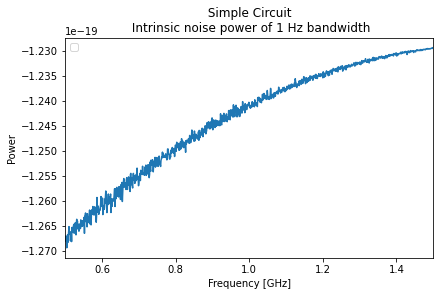

In [7]:
plot_cs_simple_circuit()

/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


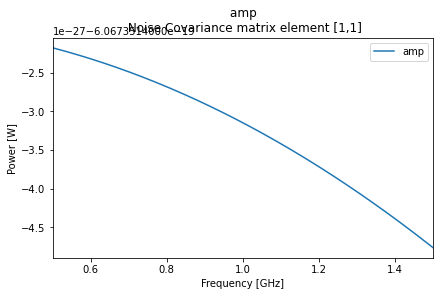

In [8]:
#Terminator
termi_temp = Troom
ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # [[What determines gamma_0 here?]]
noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, termi_temp) ## <------ function parameter

#Cables
LEN_CABLE1 = 0.01 #m
LEN_CABLE2 = 0.01 #m

noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom)
noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)

#Amplifier
amplifier = make_amplifier(freq, 21.3)
noisy_amp = read_in_noisy_network(amplifier,freq,Troom)

ideal_amplifier = make_ideal_amplifier(freq, 21.3)
noisy_ideal_amp = read_in_noisy_network(amplifier,freq,Troom)



# plt.plot(freq.f/1e9,noisy_ideal_amp.cs[:,1,1],label='ideal amp')


plt.plot(freq.f/1e9,noisy_amp.cs[:,1,1],label='amp')

# plt.show()
# plt.plot(freq.f/1e9,noisy_ntw_cable_1.cs[:,1,1],label='cable')
# plt.show()

plt.xlim(0.5,1.5)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Power [W]')
plt.title(f' amp \n Noise Covariance matrix element [1,1]')
plt.legend()
plt.tight_layout(pad=0.3, w_pad=0.2, h_pad=0.2)

In [9]:
# Why is noise power negative for the amplifier??

In [10]:
def make_amplifier(freq,G):
    
    db_to_pow = lambda x: 10**(x/10)
    
    RL_1 = 15.0 
    RL_2 = 11.0
    reverse_isolation_db = -21 #mouser.com, ZX60-83LN-S+

    A = np.sqrt( db_to_pow(G) )
    reflection_1 = np.sqrt( db_to_pow(RL_1) ) #Formula ???
    reflection_2 = np.sqrt( db_to_pow(RL_2) )
    
    isolation = np.sqrt( db_to_pow(reverse_isolation_db) ) 

    s = np.zeros((len(freq), 2, 2))

    s[:,0,0] = reflection_1
    s[:,0,1] = isolation
    s[:,1,0] = A
    s[:,1,1] = reflection_2
    
    return rf.Network(frequency=freq,s=s)

/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


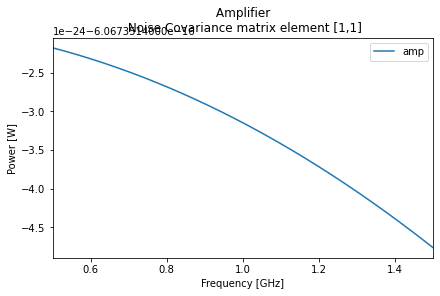

In [11]:
Troom = 300 #K
amplifier = make_amplifier(freq, 21.3) #G = 21.3 #db, Vdd = 5.0 V, typ at 2Ghz.
noisy_amp = read_in_noisy_network(amplifier,freq,Troom)

plt.plot(freq.f/1e9,noisy_amp.cs[:,1,1]/1e-3,label='amp')

plt.xlim(0.5,1.5)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Power [W]')
plt.title(f' Amplifier \n Noise Covariance matrix element [1,1]')
plt.legend()
plt.tight_layout(pad=0.3, w_pad=0.2, h_pad=0.2)

## Calculating noise power by finding noise temp first

In [60]:
def plot_cs_termi2sa():
    
    
        # Plot the power spectrum for the simple circuit setup in the lab. 
        # terminator -> cable -> amplifier -> cable -> spectrum analyzer
    
        #Terminator
        ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # what is the reflection coefficient from termi datasheet? #0.048
        noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, Troom)

        #Cables
        LEN_CABLE1 = 0.3 #m
        LEN_CABLE2 = 0.3 #m

        noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom)
        noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)
    
        
        # termi -> amp

        mnns_termi2amp = rf.MultiNoisyNetworkSystem()

        mnns_termi2amp.add(noisy_ntw_termi,'termi')
        mnns_termi2amp.add(noisy_ntw_cable_1,'cable1')
        
        mnns_termi2amp.connect('termi',1,'cable1',2)

        mnns_termi2amp.external_port('cable1',1,1)

        assem_termi2amp = mnns_termi2amp.reduce()
        
        # amp -> SA
      
        assem_amp2sa = noisy_ntw_cable_2
        
        ### Noise temperature extraction
        
        # Find Noise Temp along path to amplifier: (From Garcia-Garcia paper eqn 18)
        # print(assem_termi2amp.s.shape)
        # print(np.swapaxes(assem_termi2amp.s,1,2).shape)
        
        SAS = np.matmul(assem_termi2amp.s,np.conjugate(np.swapaxes(assem_termi2amp.s,1,2)))
        # print('sas',SAS.shape)
        # print('00',SAS[:,0,0])
        # print('0',SAS[:,0])
        T_n_termi2amp  = (1/(K_BOLTZMANN))*assem_termi2amp.cs[:,0,0]/SAS[:,0,0]

        # Find Noise Temp from amplifier to analyzer:
        # print(assem_amp2sa.s.shape)
        # print(np.swapaxes(assem_amp2sa.s,1,2).shape)
        
        A = np.array([[1, 0],[0,0]]) 
        AS  = np.matmul(A,np.conjugate(np.swapaxes(assem_amp2sa.s,1,2)))
        
        SAS = np.matmul(assem_amp2sa.s,AS)
        
        # print('sas 2',SAS.shape)
        T_n_amp2sa  = (1/(K_BOLTZMANN))*assem_amp2sa.cs[:,1,1]/SAS[:,1,1]

        # Noise Temp of JPA:
        g_amp = 10**(21.3/10)
        T_n_amp = 2*rf.NetworkNoiseCov.Tnoise(freq.f,Troom) 
        g_termi2amp = abs(assem_termi2amp.s[:,0,0])


        # Noise of path 1 + amplifier + path 2: (from Friis formula) 
        T_n_sys = T_n_termi2amp + (T_n_amp/g_termi2amp) + (T_n_amp2sa)/(g_termi2amp*g_amp) 
        P_n = K_BOLTZMANN * T_n_sys
        
        
        # plotting
        plt.plot( freq.f/1e9,10*np.log(P_n/1e-3) )
        plt.xlim(0.5,1.5);                      #plt.ylim(-361,-361+3)
        plt.xlabel('Frequency [GHz]');          plt.ylabel('Power [dBm]')
        plt.title(f' termi -> cable -> amp -> cable \n  Noise power of 1 Hz bandwidth\n')

(1001, 1, 1)
(1001, 1, 1)
sas (1001, 1, 1)
00 [0.00221811+0.j 0.00221834+0.j 0.00221809+0.j ... 0.00215008+0.j
 0.00215008+0.j 0.0021501 +0.j]
0 [[0.00221811+0.j]
 [0.00221834+0.j]
 [0.00221809+0.j]
 ...
 [0.00215008+0.j]
 [0.00215008+0.j]
 [0.0021501 +0.j]]
(1001, 2, 2)
(1001, 2, 2)
sas 2 (1001, 2, 2)


/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


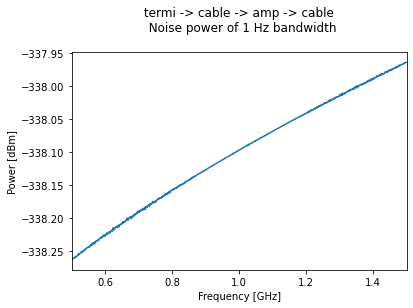

In [61]:
plot_cs_termi2sa()